![](http://upload.wikimedia.org/wikipedia/commons/7/7d/American_Sign_Language_ASL.svg)

## 1. Introduction

This notebook is aimed at beginners who want a fully explained example of how to build and optimize an image recognition model using TensorFlow.
In this notebook I will outline how to process, create and implement a convolutional NN for the MNIST sign language dataset using TensorFlow with Keras. 
I will also include some EDA and provide some code for making nice image visualisations which could be used in a wide range of other image recognition tasks. 
I hope you find this book helpful!

1. Introduction
2. Data Loading and Preprocessing
3. EDA and Image Visualisation
4. Augmentations
5. Creating A Convolutional Neural Network with TF 
6. Training The Model
7. Plotting Metrics
8. Optimizing The Model
9. Optimized Model Metrics
10. Model Evaluation
11. Discussing The Results
12. Conclusions

In [1]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

## 2. Data Loading and Preprocessing

First we need to load the training and testing data from the csv files.
Lets take a look at our column labels to see what data we have:

Both the training and testing data are stored as 785 columns where the first column 'label' contains numbers 0 - 25 representing letters of the alphabet and the remaining 784 columns contain values (0 - 255) which correspond to pixel intensities for the 28x28 pixel images of each sign language hand gesture.

We need to seperate the labels (Y) column from the pixel columns (X) for training and evaluation. The 784 pixel values for each example also need to be reshaped into a 28x28 array to construct the images.

In [2]:
# Paths to training and testing csv files
ROOT = "../input/sign-language-mnist/"
test_path = ROOT + "sign_mnist_test/sign_mnist_test.csv"
train_path = ROOT + "sign_mnist_train/sign_mnist_train.csv"

In [3]:
# Visulaising the training data column headings
with open(train_path) as file:
    data = csv.reader(file)
    for i, row in enumerate(data):
        if i == 0:
            print(row)

['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel91'

Here is a function to extract all the data we need:
Both the train and test csv files can be passed into this to return the labels seperately from the 28 x 28 image arrays.

We also need to split off part of the training set (20 % of the data) for model validation. This is data that we wont show the model during training to allow us to check the models performing after each training epoch on data it hasnt been trained on. If we used the test set for validation during model optimization, there is a chance we could overfit our model to the test data so we will save the test set for only a final model check after optimization.

In [4]:
# Extracts data from csv files
def get_data(file_path):
    with open(file_path) as file:
        data = csv.reader(file)
        labels = []
        images = []
        for i, row in enumerate(data):
            if i == 0:
                continue
            labels.append(row[0])
            image = row[1:]
            image_array = np.array_split(image, 28)
            images.append(image_array)
    return np.array(images).astype(float), np.array(labels).astype(float)

# Extract data from train and test csv files
train_images, train_labels = get_data(train_path)
test_images, test_labels = get_data(test_path)

# Create validation data set
split = 0.8
train_split = int(split*len(train_labels))
validation_images = train_images[train_split:]
validation_labels = train_labels[train_split:]
train_images = train_images[:train_split]
train_labels = train_labels[:train_split]

In [5]:
print("There are {} training images of shape {} by {} with {} labels. There are {} validation images of shape {} by {} with {} labels. There are {} test images of shape {} by {} with {} labels".format(train_images.shape[0], train_images.shape[1], train_images.shape[2], train_labels.shape[0], validation_images.shape[0], validation_images.shape[1], validation_images.shape[2], validation_labels.shape[0], test_images.shape[0], test_images.shape[1], test_images.shape[2], test_labels.shape[0]))

There are 21964 training images of shape 28 by 28 with 21964 labels. There are 5491 validation images of shape 28 by 28 with 5491 labels. There are 7172 test images of shape 28 by 28 with 7172 labels


## 3. EDA and Image Visualisation

Now that we have finished processing our data, lets explore it.

Firstly how is the data spread around the different classes i.e. the different hand signs?
The bar chart below shows that there isn't the exact same number of images for each class in the train set, but there is still a good number of each. This variation is also reflected in the test set.


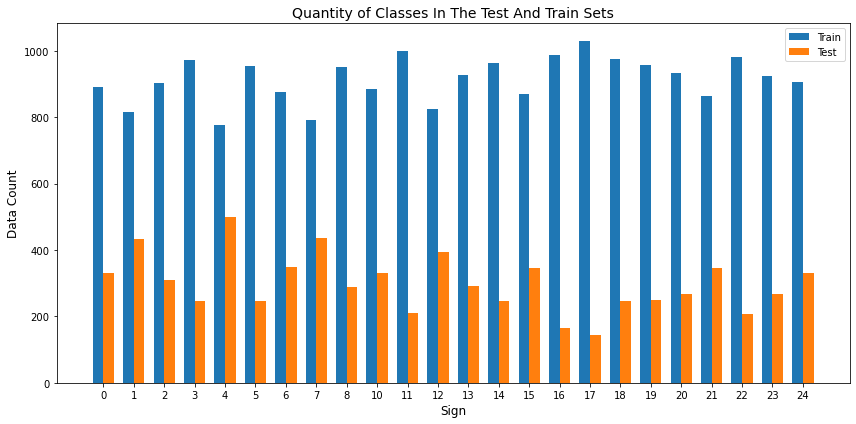

In [6]:
# Returns a list of unique labels and number of occurances for each
def counter(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return list(unique.astype(int)), list(counts)

unique_train, counts_train = counter(train_labels)
unique_test, counts_test = counter(test_labels)

# Plotting bar chart of the counts for training and testing labels
# bar locations and width
x = np.arange(len(unique_train))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12,6))
test = ax.bar(x - width/2, counts_train, width, label='Train')
train = ax.bar(x + width/2, counts_test, width, label='Test')

# Add text for labels, title and x-axis tick labels
ax.set_ylabel('Data Count', fontsize=12)
ax.set_xlabel('Sign', fontsize=12)
ax.set_title('Quantity of Classes In The Test And Train Sets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(unique_train)
ax.legend()

fig.tight_layout()

plt.show()

Now lets take a look at the actual training images.

Later we will be using augmentations during training to help artificially increase the training dataset. These are small changes to the exisiting images which help the model to see a greater data range. Visualising the training images will help us decide how to apporach this augmentation process.
The figure below shows a selection of training images which are 28x28 arrays of hand gestures. 

Generally the hands are centered in the middle of the image though some do show a small amount of displacement from the very center. This means that adding augmentations like image shift may help to artificially increase our dataset by simulating these shifts. 

If you compare the 3rd and 4th images in the 1st row you can see that they are both labelled '2.0' meaning they are the same hand gesture. However, the hands are rotated at different angles. This means that adding a rotation augmentation might be a good idea.

Some of the hands seem bigger than others, using zoom augmentations may also help with training. 

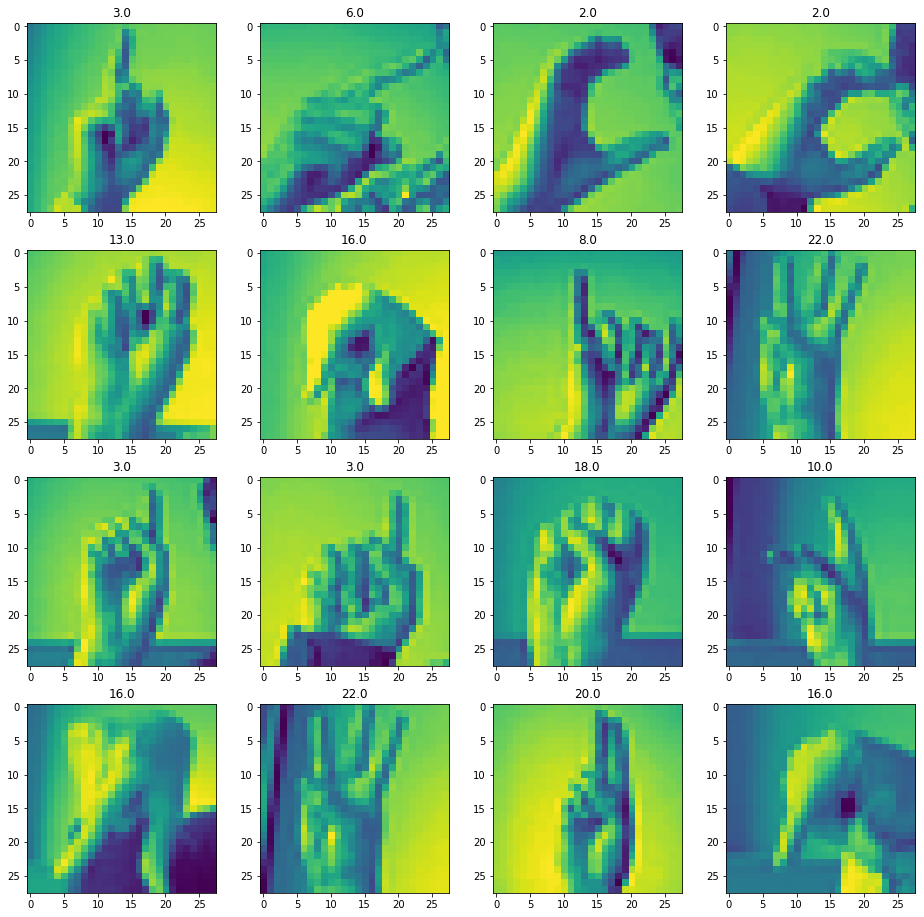

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
[axi.set_axis_off() for axi in axs.ravel()]
for i, image in enumerate(train_images[:16]):
    a = fig.add_subplot(4, 4, i + 1)
    plt.imshow(image)
    a.set_title(train_labels[i])

plt.show()

## 4. Augmentations

To apply augmentations to our data we can use ImageDataGenerator. We will flow our training images through this generator and into the model allowing the chosen augmentations to be randomly performed on the fly. The image augmentations are only done on the training set. For the validation and test sets we will still flow the images through ImageDataGenerator before thay are passed into the model for evaluation but pixel value normalization (from 0 - 255 to 0 - 1) will be the only augmentation.

Below you can take a look at the augmentations which are achieved by passing just 1 image through the training ImageDataGenerator. The image is flipped, rotated, zoomed and sheared to make it seem like a new, but realistic image each time!

In [8]:
# Converting image dimensions to (X, 28, 28, 1)
train_images = np.expand_dims(train_images, axis=3)
validation_images = np.expand_dims(validation_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

# Training ImageGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = train_datagen.flow(train_images, train_labels, batch_size=32)

# Validation ImageGenerator
valid_datagen = ImageDataGenerator(
    rescale=1/255.)

valid_gen = valid_datagen.flow(validation_images, validation_labels, batch_size=32)

# Testing Image Generator
test_datagen = ImageDataGenerator(
    rescale=1/255.)

test_gen = test_datagen.flow(test_images, test_labels, batch_size=32)

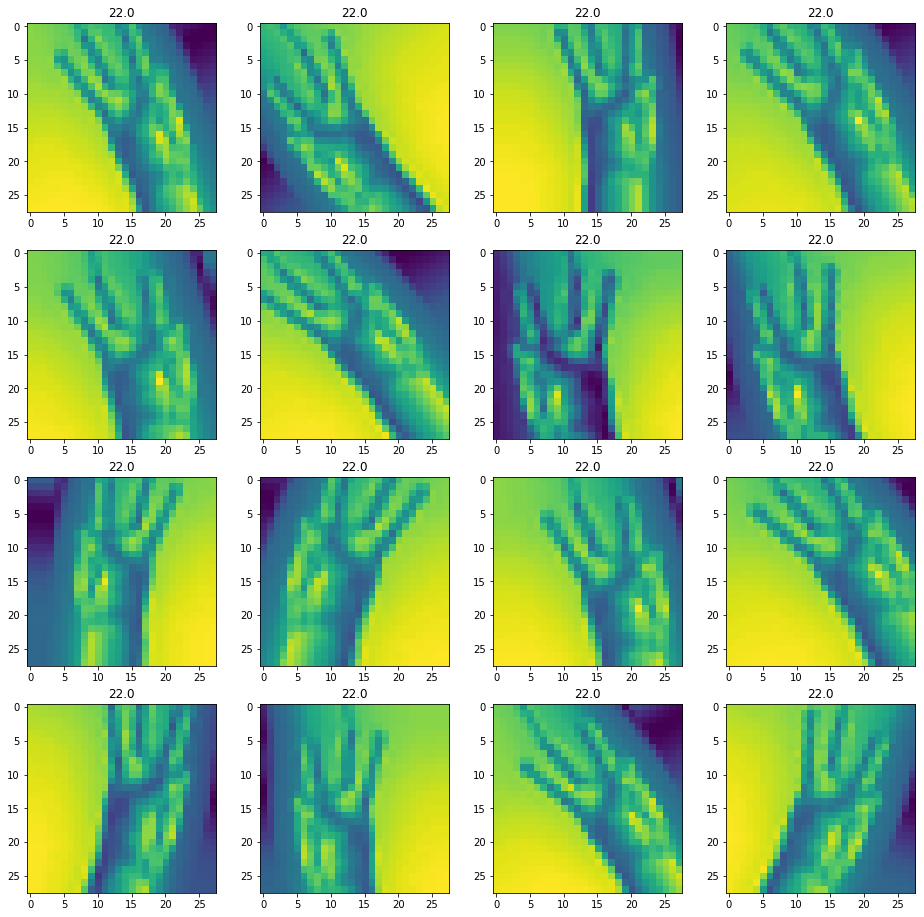

In [9]:
# Choosing an example image for augmentation
example_image = train_images[7:8]
example_label = train_labels[7:8]
example_gen = train_datagen.flow(example_image, example_label, batch_size=1)

# Plotting a grid of the example image after augmentation
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range (16):
    x_batch, y_batch = next(example_gen)
    a = fig.add_subplot(4, 4, i + 1)
    image = x_batch[0]
    plt.imshow(image[:, :, -1])
    a.set_title(y_batch[0])
plt.show()

## 5. Creating A Convolutional Neural Network with TF 

Now that the data has been sorted into training, validation and testing sets and passed into the ImageDataGenerators we are ready to make a model.

Here I create a convolutional neural network by using keras to define each layer sequentially; you can see more information about sequential models https://keras.io/api/models/sequential/ and different types of layer https://keras.io/api/layers/ here.

In the first layer it is important to specify the shape of the data being passed in. For our 28x28 greyscale images, this shape is (28, 28, 1).
We will start with a fairly simple model: 
I am using just 2 convolutional layers with 64 convolutional filters of dimensions 3x3 and a relu activation each time, though all of these parameters could be tuned. These layers extract image features from the pixel arrays.
After each convolution the data is downsampled using a maxpooling layer with a 2x2 poolsize.
After these convolutional layers the matrix output of the convolutions is flattened into a single array which is passed into densely connected layers which terminate in a 24 node softmax output layer which chooses the most probable label.

To complete the model it is compiled using Adam as the optimiser and sparse categorical crossentropy and accuracy as the metrics for evaluation. 

Here is the final code and a summary of the models structure:

In [10]:
# Defining the CNN 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Printing a summary of the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dense_1 (Dense)              (None, 26)                1

## 6. Training The Model

And thats it! We have prepared our data and created the model and now it needs to be trained. 
The training images are passed into the model and augmented using the train generator and the validation data is passed in also. 
For this first attempt I am training for 10 epochs.

In [11]:
# Fitting the model to the training data
history = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_images)/32,
    epochs=10, validation_data=valid_gen,
    validation_steps=len(validation_images)/32
)


Epoch 1/10
687/686 [==============================] - 11s 15ms/step - loss: 2.2592 - accuracy: 0.3001 - val_loss: 0.9363 - val_accuracy: 0.7195
Epoch 2/10
687/686 [==============================] - 10s 15ms/step - loss: 1.1311 - accuracy: 0.6303 - val_loss: 0.4588 - val_accuracy: 0.8383
Epoch 3/10
687/686 [==============================] - 10s 15ms/step - loss: 0.7617 - accuracy: 0.7486 - val_loss: 0.3212 - val_accuracy: 0.8794
Epoch 4/10
687/686 [==============================] - 10s 14ms/step - loss: 0.5499 - accuracy: 0.8180 - val_loss: 0.2355 - val_accuracy: 0.9210
Epoch 5/10
687/686 [==============================] - 10s 14ms/step - loss: 0.4374 - accuracy: 0.8540 - val_loss: 0.1497 - val_accuracy: 0.9465
Epoch 6/10
687/686 [==============================] - 10s 14ms/step - loss: 0.3529 - accuracy: 0.8837 - val_loss: 0.1057 - val_accuracy: 0.9681
Epoch 7/10
687/686 [==============================] - 10s 15ms/step - loss: 0.3044 - accuracy: 0.9011 - val_loss: 0.1076 - val_accuracy:

## 7. Plotting Metrics

We can plot the metrics (loss and accuracy) for both the training and validation set to see how our model progressed during training. 

Even on this first attempt, the model did pretty well: both the training and validation accuracy increased well over the sequential epochs.
Normally we would expect the validation loss to be higher than for the training set, but here it is lower. This means that the model is better at predicting labels for the validation data which it hasn't seen before than it is at predicting labels for the training set which it has seen before. This is most likely caused by the augmentations which are only performed on the training data.

For both datasets the accuracy curve flattens to show reduced learning improvement near the end of training. After these 10 epochs we ended with about 94% and 99% accuracy for the training and validation sets which is a good first attempt. But could it be improved more?


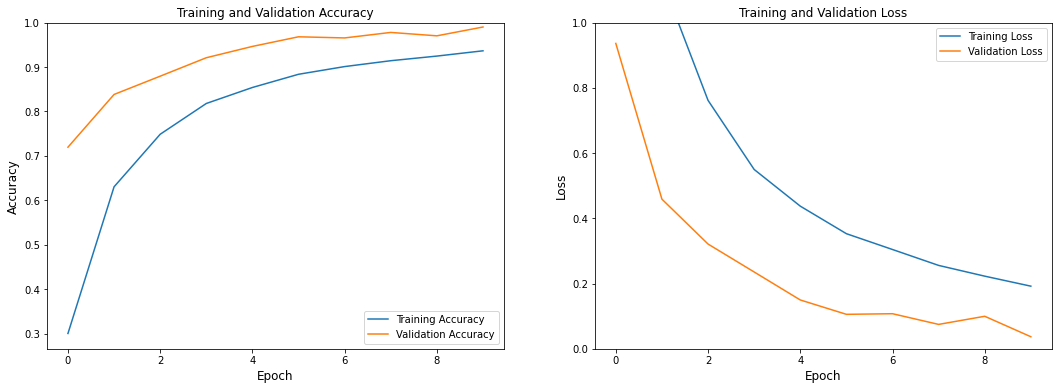

In [12]:
# Metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.show()

## 8. Optimizing The Model

How can we make the model even better?
Now that we have the full model framework and evaluation process set out, it should be relatively easy for us to try to improve our model. There are quite a few different things that we can try:

1. Adding more convolutional layers to the model - this may allow the model to extract more important image features.
2. Changing the number of convolutional filters applied per convolutional layer
3. Adding different model layers like drop out and batch normalisation to help stabilize the learning proccess. 
4. Adding a learning rate optimiser which reduces learning rate as the model converges to help direct it to the loss minimum
5. Trying different augmentations
6. Training for longer 

In practice different ideas should be tested in a systematic way over several iterations, but for demonstration purposes I will make a few of these changes at once to the model so we can see how it affects the accuracy and loss. 


In [13]:
# Modified Augmentations
train_datagen2 = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30, #Reduced the rotation range
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    # Removed Flip which might change the meaning of a sign
    fill_mode='nearest')

train_gen2 = train_datagen2.flow(train_images, train_labels, batch_size=64) #Increased batch size

# Modified Model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(), # New layer
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # New layer
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # New layer
    tf.keras.layers.BatchNormalization(),# New layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # New layer
    tf.keras.layers.Dense(26, activation='softmax')
])

# Adding in a learning rate reducer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Compiling and printing the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

# Training
history2 = model2.fit_generator(
    train_gen2, 
    steps_per_epoch=len(train_images)/64,
    epochs=15, # Training for longer 
    validation_data=valid_gen,
    validation_steps=len(validation_images)/32, 
    callbacks=[learning_rate_reduction] 
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)         

## 9. Optimized Model Metrics

The accuracy and loss plots for Model2 are very different to the first model. 
The curves are not as smooth near the start of training but eventually converge to better metric values with > 99% accuracy for both data sets. 
There is always more optimization and hyperparameter tuning that could be performed but this result is still really good so I will now check this final model by seeing how it performs on the test set which it hasn't seen before.

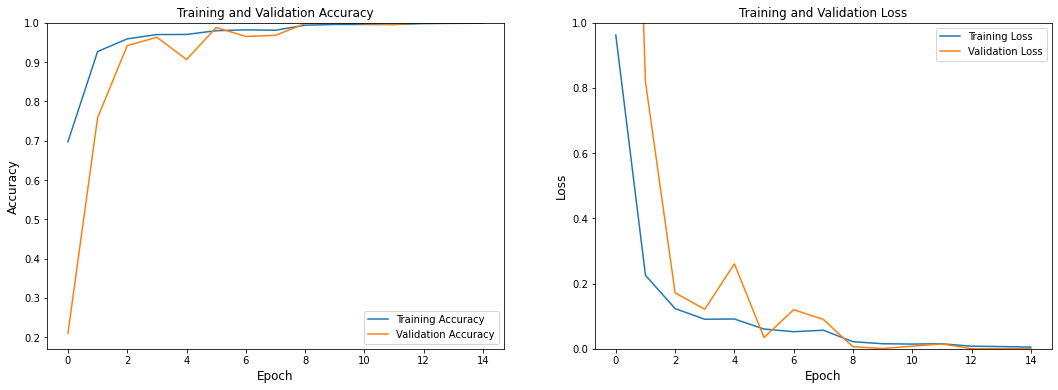

In [14]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.show()

## 10. Model Evaluation
Now that we have optimized our model lets evaluate its performance on the test set. We already created the ImageDataGenerator for this data set so we just need to pass it into the model in evaluation mode:

In [15]:
print("Evaluate on test data:")
results = model2.evaluate(test_gen, batch_size=len(test_images)/32)
print("test loss, test acc:", results)

Evaluate on test data:
225/225 [==============================] - 1s 3ms/step - loss: 6.8085e-04 - accuracy: 1.0000
test loss, test acc: [0.0006808501784689724, 1.0]


## 11. Discussing The Results

The final model achieved 100% accuracy and only a loss of only 0.0007 on the test set after only one round of model optimization which is a really great result :) 

To explore how this result was achieved we can plot the intermediate representations of the images calculated by each layer of the model. 
The image below shows how an example image is convoluted to make increasingly abstract representations as it moves through the model layers. This demonstrates how the convolutional model learns image features to identify the object in the image. 

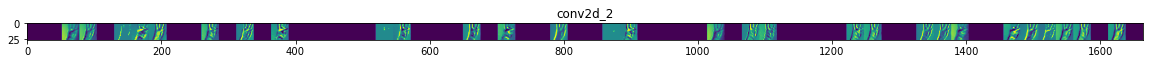

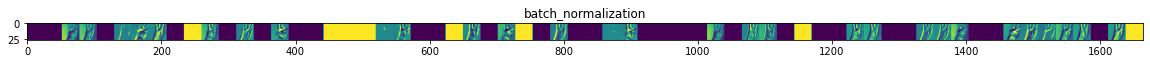

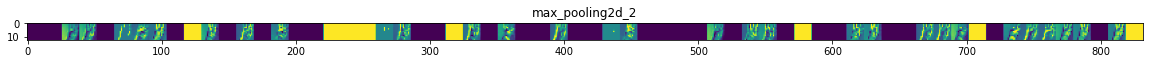

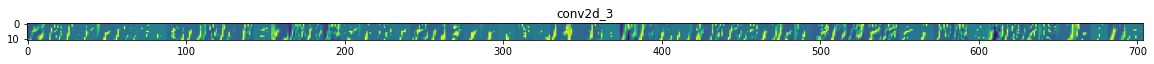

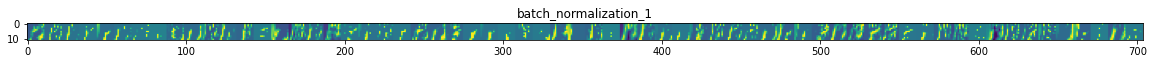

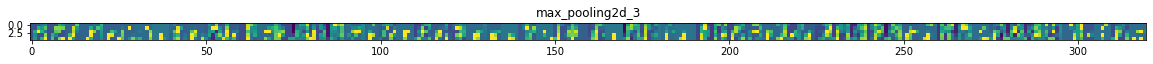

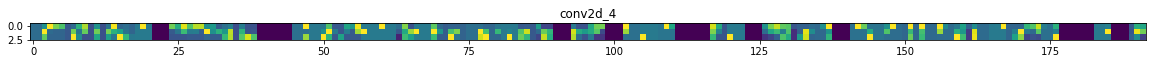

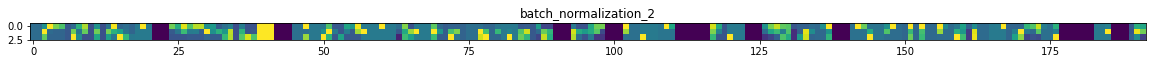

In [16]:
# Define a new model that takes an image as input and outputs intermediate representations layers Model2
successive_outputs = [layer.output for layer in model2.layers]
visualization_model = tf.keras.models.Model(inputs = model2.input, outputs = successive_outputs)
# Pass the example image into the model
successive_feature_maps = visualization_model.predict(example_gen)

# Plotting the intermdiate image representations
# Layer names in plot
layer_names = [layer.name for layer in model2.layers]
# Plotting only conv / maxpool/ batchnorm. layers, not Dense layers
np.seterr(divide='ignore', invalid='ignore')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # number of features in feature map
    n_features = feature_map.shape[-1] 
    # Feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Visualisations
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 12. Conclusions

* In this notebook the MNIST dataset of sign language images was pre-processed and augmented using ImageDataGenerator. 

* Data EDA and visualisation was performed.

* A simple CNN was made using tensorflow and trained to acheieve 94% training accuracy and 99% validation accuracy on the MNIST images.

* Methods for improving the model were discussed and some of these were tried to achieve a new model with > 99% accuracy for both the train and validation datasets.

* The models performance on the test set was evaluated to show 100% accuracy - a really great result. 

I hope you have enjoyed reading this notebook and will find it helpful in your own work :) 
